# Лабораторная работа 2. Модели представления текстов

### Задание 1. Подготовка текстового корпуса
- Прочитайте описание задачи Sentiment analysis: https://www.kaggle.com/c/sentiment-analysis-in-russian.
- Скачайте файлы `train.json` и `test.json`: https://www.kaggle.com/c/sentiment-analysis-in-russian/data.
- Загрузите в ноутбук скачанные файлы, выведите информацию по ним.

In [37]:
import pymorphy2
import re 
import string
import json
import sys
import os.path
import time
import matplotlib.pyplot as plt
from razdel import tokenize, sentenize
from nltk.tokenize import word_tokenize
import pandas as pd
from nltk.corpus import stopwords
import nltk
import numpy as np
import collections
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import gensim.downloader

In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wqano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Wqano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
morph = pymorphy2.MorphAnalyzer()

In [40]:
ENCODING = 'utf-8'
POS = 'pos'
WORDFREQ = 'wordFreq'
LEMMA = 'lemma'
IN_DICT = 'in_dict'
WORDFORM = 'wordform'
GENDER = 'gender'
NUMBER = 'number'
ANIMACY = 'animacy'
WORDFORMS =  'wordforms'
COUNT_ALL = 'count_all'

DATA_TRAIN = 'train.json'
DATA_TEST = 'test.json'

FILE_NAME = 'file_name'
FILE_TEXT = 'file_text'
FILE_SIZE = 'file_size'
TIME_PARSE = 'time_parse'

ID_JSON = 'id'
TEXT_JSON = 'text'
SENTIMENT_JSON = 'sentiment'
SENTIMENTS = ['negative', 'positive', 'neutral']

MODEL_FOLDER = 'models/'
POS_STOP = []

In [8]:
def get_data_from_file(file_name):
    document = dict
    with open(file_name , 'r', encoding = ENCODING) as fl:
        document = json.load(fl)
        fl.close()
    return document

In [9]:
def get_class_from_train_file():
    class_from_train_file = {}
    document = dict
    with open(DATA_TRAIN , 'r', encoding = ENCODING) as fl:
        document = json.load(fl)
        fl.close()
    for text in document:
        if text[SENTIMENT_JSON] in class_from_train_file:
            class_from_train_file[text[SENTIMENT_JSON]].append(text[TEXT_JSON])
        else:
            class_from_train_file.update({text[SENTIMENT_JSON]:[text[TEXT_JSON]]})
    return class_from_train_file

In [10]:
test_document = get_data_from_file(DATA_TEST)
train_document = get_data_from_file(DATA_TRAIN)

In [11]:
class_from_file = get_class_from_train_file()

In [12]:
def get_lens_text(document):
    lens = []
    for text in document:
        lens.append(len(text[TEXT_JSON]))
    return lens

In [13]:
def get_max_len_text(document):
    return np.array(get_lens_text(document)).max()

In [14]:
def get_min_len_text(document):
    return np.array(get_lens_text(document)).min()

In [15]:
def get_mean_len_text(document):
    return np.array(get_lens_text(document)).mean()

In [16]:
def get_median_len_text(document):
    return np.median(get_lens_text(document))

In [17]:
print('Общее количество текстов train.json: ', len(test_document))
print('Общее количество текстов train.json: ', len(train_document))
print('Распределение по классам train.json:')
for class_ in SENTIMENTS:
    print(class_,':',len(class_from_file[class_]))
    
print('Максимальная длина текста train.json:', get_max_len_text(train_document))
print('Минимальная длина текста train.json:', get_min_len_text(train_document))
print('Максимальная длина текста test.json:', get_max_len_text(test_document))
print('Минимальная длина текста test.json:', get_min_len_text(test_document))

print('Средняя длина текстов train.json:', get_mean_len_text(train_document))
print('Средняя длина текстов train.json:', get_mean_len_text(train_document))
print('Медиана длин текстов test.json:', get_median_len_text(test_document))
print('Медиана длин текстов test.json:', get_median_len_text(test_document))

Общее количество текстов train.json:  2056
Общее количество текстов train.json:  8263
Распределение по классам train.json:
negative : 1434
positive : 2795
neutral : 4034
Максимальная длина текста train.json: 381498
Минимальная длина текста train.json: 28
Максимальная длина текста test.json: 320754
Минимальная длина текста test.json: 35
Средняя длина текстов train.json: 3911.85017548106
Средняя длина текстов train.json: 3911.85017548106
Медиана длин текстов test.json: 2097.5
Медиана длин текстов test.json: 2097.5


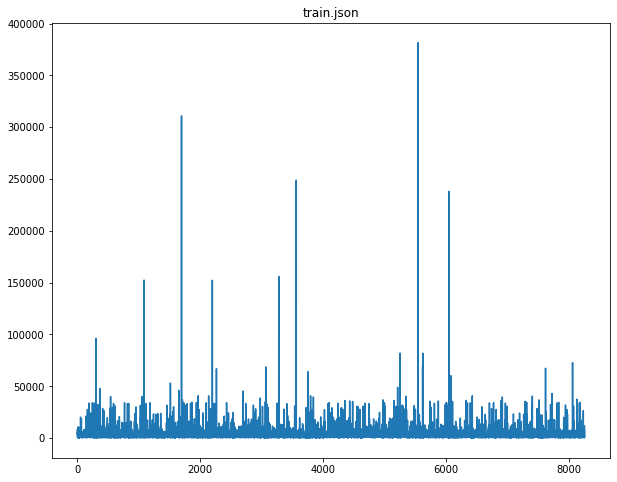

In [18]:
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(get_lens_text(train_document))
plt.title('train.json')
plt.show()

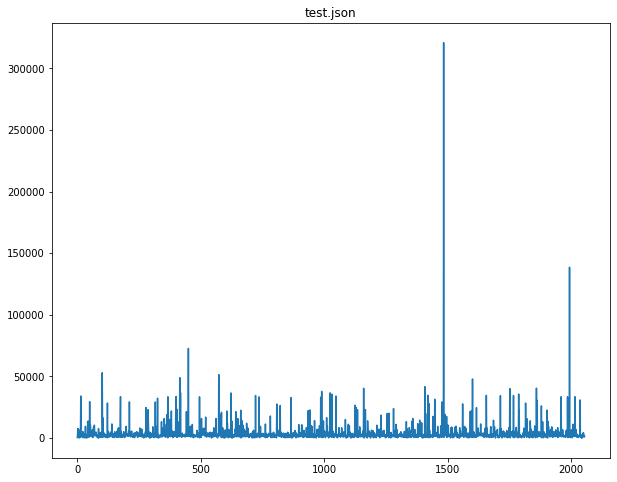

In [19]:
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(get_lens_text(test_document))
plt.title('test.json')
plt.show()

### Задание 2. Булевская модель
Напишите функцию `get_bool_model()` на входе которой текстовый корпус, на выходе – булевская матрица термин-документ.

В функции должны осуществляться следующие действия:
- все слова преобразуются в нормальную форму;
- удаляются стоп-слова;
- удаляются (или оставляются) слова заданных частей речи (список частей речи должен передаваться в виде параметра);
- удаляются слова, частотность которых во всем корпусе ниже заданного порога (параметр);
- создается словарь корпуса.

Нельзя использовать библиотечные функции `scikit-learn`.  
Можно использовать функции, разработанные в этой и предыдущей лабораторных работах.

In [20]:
def parse_text(text):
    tokens = []
    infotext = []
    tokens = word_tokenize(text.replace('\n',' '))
    for token in tokens:
        if token not in string.punctuation:
            dictinfo = {}
            p = morph.parse(token)[0]
            dictinfo.update({WORDFORM:token})
            dictinfo.update({LEMMA:p.normal_form})
            dictinfo.update({POS:p.tag.POS}) 
            dictinfo.update({IN_DICT:morph.word_is_known(token)})
            infotext.append(dictinfo)
    return infotext

In [21]:
# Формируется словарь, ключами которого являются все нормальные формы слов текста, 
# а в качестве значений хранится следующая информация:
# 1)часть речи слова;
# 2)частота слова в тексте;
# 3)все варианты словоформ в тексте с данной нормальной формой.

def get_dictionary(word_info_dict):
    result = {}
    for item in word_info_dict:
        tempDict = {}
        varForm = []
        pos = item[POS]
        lemma = item[LEMMA]
        wordform = item[WORDFORM]
        tempDict.update({POS:pos})
        varForm.append(wordform)
        if lemma in result:
            result[lemma][WORDFREQ] = result[lemma][WORDFREQ] + 1
            if wordform not in result[lemma][WORDFORMS]:
                  result[lemma][WORDFORMS].append(wordform)
        else:
            result.update({lemma: {WORDFORMS:varForm, WORDFREQ : 1, POS : pos}}) 
    return result

In [54]:
#На вход подается словарь, получаемый функцией get_dictionary
def clear_document_dict(document_dict, pos_stop=[], deletePos=True, minFreq = 0, needPos = False):
    cleared_document_dict = {}
    for part in document_dict:
        if document_dict[part] not in stopwords.words():
            if deletePos:
                if document_dict[part][POS] in pos_stop:
                    continue
                else:
                    if document_dict[part][WORDFREQ] >= minFreq:
                        if needPos:
                            cleared_document_dict.update({part:[document_dict[part][WORDFREQ], document_dict[part][POS]]})
                        else:
                            cleared_document_dict.update({part:document_dict[part][WORDFREQ]})
            else:
                if document_dict[part][POS] in pos_stop and document_dict[part][WORDFREQ] >= minFreq:
                    if needPos:
                            cleared_document_dict.update({part:[document_dict[part][WORDFREQ], document_dict[part][POS]]})
                    else:
                            cleared_document_dict.update({part:document_dict[part][WORDFREQ]})
                                      
    return cleared_document_dict

In [23]:
def get_bool_model(corpus, pos_stop=[], deletePos=True, minFreq=0):
    documents = {}
    words_in_corpus = []
    term_matrix = []
    
    for part_of_corpus in corpus:
        document_dict = get_dictionary(parse_text(part_of_corpus[TEXT_JSON]))
        
        cleared_document_dict = clear_document_dict(document_dict, pos_stop, deletePos, minFreq)
        documents.update({part_of_corpus[ID_JSON]:cleared_document_dict})
        
        for document_word in cleared_document_dict:
            if document_word not in words_in_corpus:
                words_in_corpus.append(document_word)   
         
    for word in words_in_corpus:
        word_exist = []
        for document_dict in documents:
            if word in documents[document_dict]:
                word_exist.append(True)
            else:
                word_exist.append(False)
        term_matrix.append(word_exist)
    return term_matrix, words_in_corpus

In [24]:
term_matrix_result, words_in_corpus_result = get_bool_model(train_document[0:5])

In [25]:
len(words_in_corpus_result)

1134

In [26]:
term_matrix_result = np.array(term_matrix_result)

In [27]:
term_matrix_result.shape

(1134, 5)

Постройте матрицу термин-документ для текстовых корпусов из первого задания.

In [28]:
term_doc = pd.DataFrame(data = term_matrix_result, index = words_in_corpus_result)
term_doc

,0,1,2,3,4
досудебный,True,True,False,False,False
расследование,True,True,False,False,False
по,True,True,True,True,True
факт,True,True,True,False,True
покупка,True,False,True,False,False
...,...,...,...,...,...
информационный,False,False,False,False,True
обязательный,False,False,False,False,True
авторский,False,False,False,False,True
материал,False,False,False,False,True


### Задание 3. Модель TF-IDF
Напишите функцию `get_tfidf_model()` на входе которой текстовый корпус, на выходе – матрица термин-документ c TF-IDF-весами.

В функции должны осуществляться следующие действия:
- все слова преобразуются в нормальную форму;
- удаляются стоп-слова;
- удаляются (или оставляются) слова заданных частей речи (список частей речи должен передаваться в виде параметра);
- удаляются слова, частотность которых во всем корпусе ниже заданного порога (параметр);
- создается словарь корпуса;
- вычисляются глобальные IDF-веса и сохраняются в словарь;
- слова для документов взвешиваются в соответствии со схемой TF-IDF.

Нельзя использовать библиотечные функции `scikit-learn`.  
Можно использовать функции, разработанные в предыдущей лабораторной работе.

In [57]:
def get_tfidf_model(corpus, pos_stop=[], deletePos=True, minFreq=0):
    documents = {}  #Все слова по каждому документу
    words_in_corpus = [] #Все слова в корпусе
    tf_idf_matrix = []   
    
    for part_of_corpus in corpus:
        document_dict = get_dictionary(parse_text(part_of_corpus[TEXT_JSON]))
        
        cleared_document_dict = clear_document_dict(document_dict, pos_stop, deletePos, minFreq)
        documents.update({part_of_corpus[ID_JSON]:cleared_document_dict})
        
        for document_word in cleared_document_dict:
            if document_word not in words_in_corpus:
                words_in_corpus.append(document_word)
    
    count_documents = len(corpus)       
    tf_matrix = []
    idf_matrix = []
    
  
    for word in words_in_corpus:
        tf_word_in_document = []
        idf_count_word_in_document = 0
        for document_dict in documents:
            if word in documents[document_dict].keys():
                tf_count_in_documents = documents[document_dict][word] 
                idf_count_word_in_document+=1
            else:
                tf_count_in_documents = 0
        
            tf_word_in_document.append(tf_count_in_documents / len(documents[document_dict].keys()))
            
        idf_word_in_document = np.log( count_documents / idf_count_word_in_document ) + 1

        idf_matrix.append(idf_word_in_document)
    
        tf_matrix.append(tf_word_in_document)
        
    return ( np.array(idf_matrix) * np.array(tf_matrix).T ), words_in_corpus

In [58]:
tf_idf_martix, tf_idf_words_in_corpus_result  = get_tfidf_model(train_document[0:4])

Постройте матрицу термин-документ для текстовых корпусов из первого задания.

In [59]:
tf_idf_doc = pd.DataFrame(data = tf_idf_martix.T, index = np.array(tf_idf_words_in_corpus_result))
tf_idf_doc

,0,1,2,3
досудебный,0.029704,0.012450,0.000000,0.000000
расследование,0.029704,0.012450,0.000000,0.000000
по,0.035088,0.029412,0.015414,0.028571
факт,0.022591,0.009468,0.002481,0.000000
покупка,0.014852,0.000000,0.006525,0.000000
...,...,...,...,...
завод,0.000000,0.000000,0.000000,0.008522
заёмщик,0.000000,0.000000,0.000000,0.008522
3003,0.000000,0.000000,0.000000,0.008522
собранный,0.000000,0.000000,0.000000,0.008522


Сравните результаты работы вашей функции (полученные веса) с результатами работы класса [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) из `scikit-learn`.

In [60]:
texts_of_corpus = []

for part_of_corpus in train_document[0:4]:
    texts_of_corpus.append(part_of_corpus[TEXT_JSON].replace('\n',' '))
    
vectorizer = TfidfVectorizer(tokenizer = word_tokenize, stop_words = stopwords.words(), vocabulary = tf_idf_words_in_corpus_result)
X = vectorizer.fit_transform(texts_of_corpus)
resultVec = X.toarray()
np.array(resultVec[:,:4]).T

c:\users\wqano\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", "'d", "'ll", "'re", "'s", "'ve", '.', '?', 'could', 'might', 'must', "n't", 'need', 'onların', 'sha', 'would', 'δ', 'δι', 'агар-чи', 'аз-баски', 'афташ', 'бале', 'баҳри', 'болои', 'валекин', 'вақте', 'вуҷуди', 'гар', 'гарчанде', 'даме', 'карда', 'кошки', 'куя', 'кӣ', 'магар', 'майлаш', 'модоме', 'нияти', 'онан', 'оре', 'рӯи', 'сар', 'тразе', 'хом', 'хуб', 'чаро', 'чи', 'чунон', 'ш', 'шарте', 'қадар', 'ҳай-ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳой-ҳой', 'ҳол', 'ҳолате', 'ӯим', 'أفعل', 'أفعله', 'انفك', 'برح', 'سيما', 'कम', 'से', 'ἀλλ', '’'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


array([[0.        , 0.        , 0.        , 0.        ],
       [0.08262672, 0.07756922, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.08262672, 0.        , 0.02013751, 0.        ]])

In [61]:
vectorizer.get_feature_names()[0:5]

['досудебный', 'расследование', 'по', 'факт', 'покупка']

### Задание 4. Модель word2vec
Напишите функцию `get_word2vec_model()` на входе которой текстовый корпус и модель `word2vec`, на выходе – матрица термин-документ c word2vec-весами.

В функции должны осуществляться следующие действия:
- все слова преобразуются в нормальную форму (при необходимости – в зависимости от используемой модели);
- удаляются стоп-слова;
- удаляются (или оставляются) слова заданных частей речи (список частей речи должен передаваться в виде параметра);
- удаляются слова, частотность которых во всем корпусе ниже заданного порога (параметр);
- создается словарь корпуса;
- вычисляются веса word2vec для заданной модели.


Можно использовать библиотечные функции и функции, разработанные в лабораторных работах.

In [34]:
def load_model(model_name):
    if '.vec' in model_name:
        binary = False
    else:
        binary = True
    
    rus_model = gensim.models.KeyedVectors.load_word2vec_format(model_name, binary=binary)

    return rus_model

In [83]:
model_name =  MODEL_FOLDER+'ruscorpora_1_300_10.bin'
word2vec_model = load_model(model_name)
models_dim = 300

In [84]:
def get_word2vec_model(corpus, model, models_dim, pos_stop=[], deletePos=True, minFreq=0):
    documents = {}
    words_in_corpus = []

    for part_of_corpus in corpus:
        document_dict = get_dictionary(parse_text(part_of_corpus[TEXT_JSON]))

        cleared_document_dict = clear_document_dict(document_dict, pos_stop, deletePos, minFreq, True)
        documents.update({part_of_corpus[ID_JSON]:cleared_document_dict})

        for document_word in cleared_document_dict:
            if document_word not in words_in_corpus:
                words_in_corpus.append(document_word)   
  
    doc_vecs = []
    for doc_dict in documents:
        doc_vec = np.zeros(models_dim)
        count_word_in_model = 0 
        for word in documents[doc_dict]:

            word_w2v = word + '_' + f'{documents[doc_dict][word][1]}'
    
            if word_w2v in model:
                doc_vec += word2vec_model[word_w2v]
                count_word_in_model +=1
        doc_vecs.append([x / count_word_in_model for x in doc_vec])
    
    return doc_vecs

In [85]:
word2vec_martix = get_word2vec_model(train_document[0:15], word2vec_model, models_dim)


In [86]:
word2vec_result = pd.DataFrame(data = word2vec_martix)
word2vec_result

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.023934,-0.008687,-0.032956,0.009489,-0.011051,0.022231,0.008541,0.008891,0.015125,-0.022434,...,0.001519,0.049819,-0.002391,0.001870,-0.006077,-0.032091,0.047686,0.002281,-0.027877,-0.012895
1,0.016070,-0.003818,-0.011529,0.015603,-0.015126,0.021334,0.020806,-0.005168,0.028446,-0.035297,...,0.013510,0.040641,-0.015485,-0.022496,-0.015551,-0.020503,0.016946,0.028312,-0.038103,-0.013548
2,0.011523,-0.000783,-0.008847,0.025553,-0.019018,0.008022,0.021555,0.003517,0.005667,-0.024966,...,0.012829,0.018210,-0.009192,-0.005243,-0.012805,-0.037788,0.036030,-0.004580,-0.039948,-0.022735
3,0.023945,-0.016073,-0.026701,0.019765,-0.016460,0.018205,0.013256,-0.006509,0.012204,-0.039684,...,-0.006975,0.017054,-0.010664,-0.013977,-0.012582,-0.028057,0.037667,0.000141,-0.059651,-0.013532
4,0.016851,-0.013842,-0.036093,0.029677,0.001119,0.017064,-0.000674,0.012133,0.024788,-0.017186,...,0.020291,0.033038,-0.017271,-0.017003,-0.006054,-0.046666,0.037001,0.000553,-0.046600,-0.025502
5,0.028448,-0.003088,-0.011101,0.028269,-0.002450,0.022188,-0.004184,0.000209,0.022416,-0.005267,...,0.021770,0.033220,-0.000242,-0.010680,-0.025033,-0.024880,0.050306,-0.010670,-0.036408,-0.022077
6,0.025339,-0.003056,-0.017242,0.014689,-0.015596,0.017846,0.038924,0.001300,0.032265,-0.023614,...,0.022517,0.046839,0.004064,-0.020941,-0.025915,-0.018753,0.019399,0.021453,-0.042191,-0.017832
7,0.026121,-0.011937,-0.021963,0.002474,-0.004494,0.006243,0.003413,-0.014271,0.020744,-0.017904,...,-0.007230,0.053085,-0.002833,0.004816,-0.011281,-0.020427,0.046219,-0.021224,-0.038046,-0.023782
8,0.025930,-0.006725,-0.034121,0.026734,-0.012138,0.029758,0.001253,0.012213,0.023585,-0.014508,...,0.038701,0.041285,-0.029444,-0.010987,-0.008555,-0.038423,0.041754,0.010717,-0.044982,-0.022890
9,0.019709,0.008111,-0.008761,0.023691,-0.011744,0.008683,-0.004930,0.010889,0.017181,-0.006977,...,0.007169,0.033860,0.001008,0.004584,-0.028687,-0.031511,0.017670,0.016621,-0.022145,-0.016303


In [46]:
list(word2vec_model.key_to_index)[:10]

['весь_DET',
 'человек_NOUN',
 'мочь_VERB',
 'год_NOUN',
 'сказать_VERB',
 'время_NOUN',
 'говорить_VERB',
 'становиться_VERB',
 'знать_VERB',
 'самый_DET']